In [1]:
import os, json
from utils import session_config
from data_loader import load_data, Episode_generator
from models import load_model
from trainers.train_utils import calc_prototypes, calc_euclidian_dists, calc_probability_with_dists, loss_func, cal_metric

from functools import partial
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
session_config.setup_gpus(True, 0.9)

1 Physical GPUs, 1 Logical GPUs


# 1. load configuration file

In [3]:
config_filename = "configs/mini_imagenet_fsl.json"

In [4]:
with open(config_filename, "r") as file:
    config = json.load(file)

In [5]:
print(config)

{'dataset_name': 'mini_imagenet', 'data_dir': '/home/files/datasets/mini_imagenet', 'input_shape': [84, 84, 3], 'model_name': 'prototypical_networks', 'checkpoint_dir': 'checkpoints/protonet_lr_up', 'train': {'gpu_id': '0', 'n_epoch': 300, 'n_episode': 100, 'n_way': 30, 'n_support': 5, 'n_query': 15, 'learning_rate': 0.005, 'patience': 50, 'pretrained_type': 'base', 'checkpoint_name': 'None'}, 'test': {'gpu_id': '0', 'n_episode': 100, 'n_way': 5, 'n_support': 5, 'n_query': 15, 'pretrained_type': 'latest', 'checkpoint_name': 'None'}}


In [6]:
print(config["train"])

{'gpu_id': '0', 'n_epoch': 300, 'n_episode': 100, 'n_way': 30, 'n_support': 5, 'n_query': 15, 'learning_rate': 0.005, 'patience': 50, 'pretrained_type': 'base', 'checkpoint_name': 'None'}


In [7]:
print(config["test"])

{'gpu_id': '0', 'n_episode': 100, 'n_way': 5, 'n_support': 5, 'n_query': 15, 'pretrained_type': 'latest', 'checkpoint_name': 'None'}


# 2. load data pipeline

In [8]:
#ds = load_data(["train", "val", "test"], config)
ds = load_data(["train", "val", "test"], config)

In [9]:
ds["val"].shape #shape of data

(16, 600, 84, 84, 3)

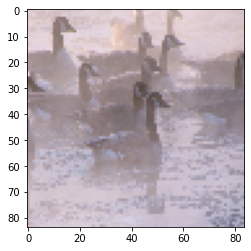

In [10]:
plt.imshow(ds["val"][0,0])

In [11]:
print(ds["val"][0,0,:10,:10])

[[[0.8745098  0.8        0.78431373]
  [0.85882353 0.78431373 0.76862745]
  [0.85098039 0.77647059 0.76078431]
  [0.85490196 0.77647059 0.78431373]
  [0.87843137 0.8        0.80392157]
  [0.83921569 0.76470588 0.74901961]
  [0.83921569 0.76862745 0.76470588]
  [0.8745098  0.81176471 0.81960784]
  [0.87058824 0.79607843 0.80392157]
  [0.85490196 0.78039216 0.80392157]]

 [[0.89803922 0.83529412 0.83921569]
  [0.8745098  0.80784314 0.81176471]
  [0.87058824 0.80784314 0.81176471]
  [0.85882353 0.78039216 0.78823529]
  [0.83529412 0.75686275 0.76078431]
  [0.82745098 0.75294118 0.75686275]
  [0.82745098 0.75294118 0.76078431]
  [0.85490196 0.78823529 0.81176471]
  [0.84313725 0.76862745 0.79215686]
  [0.83137255 0.75686275 0.77254902]]

 [[0.85098039 0.77647059 0.78431373]
  [0.85882353 0.78431373 0.79215686]
  [0.90980392 0.83529412 0.84313725]
  [0.88235294 0.80392157 0.80784314]
  [0.83529412 0.75686275 0.76470588]
  [0.82352941 0.76078431 0.76470588]
  [0.83921569 0.76862745 0.7764705

In [12]:
n_way = config["train"]["n_way"]
n_support = config["train"]["n_support"]
n_query = config["train"]["n_query"]
Epi_gen = Episode_generator(ds["train"], n_way, n_support, n_query)
train_ds = Epi_gen.pipeline()


val_n_way = config["test"]["n_way"]
val_n_support = config["test"]["n_support"]
val_n_query = config["test"]["n_query"]
Epi_gen = Episode_generator(ds["val"], val_n_way, val_n_support, val_n_query)
val_ds = Epi_gen.pipeline()

Epi_gen = Episode_generator(ds["test"], val_n_way, val_n_support, val_n_query)
test_ds = Epi_gen.pipeline()

In [13]:
for i, (support,query) in enumerate(train_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (30, 5, 84, 84, 3)
query set (30, 15, 84, 84, 3)


In [14]:
for i, (support,query) in enumerate(val_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (5, 5, 84, 84, 3)
query set (5, 15, 84, 84, 3)


In [15]:
for i, (support,query) in enumerate(test_ds.take(1)):
    print("{}-th episode".format(i+1))
    print("support set", support.shape)
    print("query set", query.shape)

1-th episode
support set (5, 5, 84, 84, 3)
query set (5, 15, 84, 84, 3)


# 1. load Prototypical network 

In [16]:
model = load_model(config)

In [17]:
H,W,C = config["input_shape"]
model(np.ones([1,H,W,C], np.float32))

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.1107205 , 0.00757065, 0.0233342 , 0.        , 0.0144216 ,
        0.04551765, 0.05303074, 0.00148846, 0.1679472 , 0.08562344,
        0.00291181, 0.01344281, 0.        , 0.00805448, 0.02265614,
        0.00333415, 0.        , 0.08150029, 0.03447915, 0.08723903,
        0.00537449, 0.0742593 , 0.00425598, 0.06204113, 0.05089346,
        0.01538387, 0.07784276, 0.        , 0.02101702, 0.05092724,
        0.        , 0.0183095 , 0.00656265, 0.18053904, 0.10052773,
        0.00890177, 0.        , 0.01066288, 0.03224792, 0.        ,
        0.02181062, 0.14680949, 0.0375515 , 0.03744673, 0.11999565,
        0.03667795, 0.00026148, 0.00351727, 0.09459475, 0.01220587,
        0.03261625, 0.        , 0.0500125 , 0.11455096, 0.04088719,
        0.06456434, 0.        , 0.01006038, 0.0317213 , 0.03186969,
        0.01996206, 0.00938229, 0.00966507, 0.        ]], dtype=float32)>

In [18]:
model.encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 84, 84, 64)           1792      
_________________________________________________________________
batch_normalization (BatchNo (1, 84, 84, 64)           256       
_________________________________________________________________
re_lu (ReLU)                 (1, 84, 84, 64)           0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 42, 42, 64)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 42, 42, 64)           36928     
_________________________________________________________________
batch_normalization_1 (Batch (1, 42, 42, 64)           256       
_________________________________________________________________
re_lu_1 (ReLU)               (1, 42, 42, 64)           0

# Training

In [19]:
log_dir = os.path.join('logs', "protonet_gap")
if os.path.isdir(log_dir):
        raise ValueError("log directory exists. checkout your experiment name in configure file.")
summary_writer = tf.summary.create_file_writer(log_dir)

In [20]:
@tf.function
def train_step(query, support, model, optimizer, n_way, n_query, n_support):
    with tf.GradientTape() as tape:
        query_embeddings = model(query)
        support_embeddings = model(support)

        prototypes = calc_prototypes(support_embeddings, n_way, n_support)
        dists = calc_euclidian_dists(query_embeddings, prototypes)
        log_p_y = calc_probability_with_dists(dists, n_way, n_query)
        loss, pred = loss_func(log_p_y, n_way, n_query)
        eq, acc = cal_metric(log_p_y, n_way, n_query)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, eq, acc

@tf.function
def val_step(query, support, model, n_way, n_query, n_support):
    query_embeddings = model(query)
    support_embeddings = model(support)
    
    prototypes = calc_prototypes(support_embeddings, n_way, n_support)
    dists = calc_euclidian_dists(query_embeddings, prototypes)
    log_p_y = calc_probability_with_dists(dists, n_way, n_query)
    loss, pred = loss_func(log_p_y, n_way, n_query)
    eq, acc = cal_metric(log_p_y, n_way, n_query)
    return loss, eq, acc

In [21]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=config["train"]["learning_rate"])

n_epoch = config["train"]["n_epoch"]
n_episode = config["train"]["n_episode"]
val_n_episode = config["test"]["n_episode"]

trainer = partial(train_step, model=model, optimizer=adam_optimizer, n_way=n_way, n_query=n_query, n_support=n_support)
validator = partial(val_step, model=model, n_way=val_n_way, n_query=val_n_query, n_support=val_n_support)

In [22]:
for epoch in range(n_epoch):
    train_loss = tf.metrics.Mean(name='train_loss')
    val_loss = tf.metrics.Mean(name='val_loss')
    train_acc = tf.metrics.Mean(name='train_accuracy')
    val_acc = tf.metrics.Mean(name='val_accuracy')
    
    print("{} epoch start".format(epoch+1))
    #Training
    for episode, (support, query) in enumerate(train_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = trainer(query, support)
        train_loss(loss)
        train_acc(acc)
        if ((episode+1)%20) == 0:
            print("Episode {}".format(episode+1))
        if episode+1 == n_episode:
            break
    #validation 
    for episode, (support, query) in enumerate(val_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = validator(query, support)
        val_loss(loss)
        val_acc(acc)
        if episode+1 == val_n_episode:
            break
    print("{} epoch end. Loss : {}, Accuracy : {}, Val-loss : {}, Val-Accuracy : {}".format(epoch+1, 
                                                                                             train_loss.result(),
                                                                                             train_acc.result(),
                                                                                             val_loss.result(),
                                                                                             val_acc.result() ))
    with summary_writer.as_default():
                tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
                tf.summary.scalar('train_acc', train_acc.result(), step=epoch)
                tf.summary.scalar('val_loss', val_loss.result(), step=epoch)
                tf.summary.scalar('val_acc', val_acc.result(), step=epoch)

1 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
1 epoch end. Loss : 3.2482903003692627, Accuracy : 0.09880001842975616, Val-loss : 1.5318138599395752, Val-Accuracy : 0.3169333040714264
2 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
2 epoch end. Loss : 3.153118371963501, Accuracy : 0.11102218925952911, Val-loss : 1.5013799667358398, Val-Accuracy : 0.3329333961009979
3 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
3 epoch end. Loss : 3.1025705337524414, Accuracy : 0.11944445967674255, Val-loss : 1.4916822910308838, Val-Accuracy : 0.3434666693210602
4 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
4 epoch end. Loss : 3.0885632038116455, Accuracy : 0.12160001695156097, Val-loss : 1.4518144130706787, Val-Accuracy : 0.3680000603199005
5 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
5 epoch end. Loss : 2.9944515228271484, Accuracy : 0.15637776255607605, Val-loss : 1.3852627277374268, 

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
41 epoch end. Loss : 1.8894476890563965, Accuracy : 0.4384444057941437, Val-loss : 1.0022403001785278, Val-Accuracy : 0.6039998531341553
42 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
42 epoch end. Loss : 1.8785454034805298, Accuracy : 0.44251111149787903, Val-loss : 0.9854111671447754, Val-Accuracy : 0.6173332333564758
43 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
43 epoch end. Loss : 1.8989977836608887, Accuracy : 0.4360445439815521, Val-loss : 1.0367462635040283, Val-Accuracy : 0.5889331102371216
44 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
44 epoch end. Loss : 1.859265923500061, Accuracy : 0.4446444809436798, Val-loss : 1.013454556465149, Val-Accuracy : 0.5979999303817749
45 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
45 epoch end. Loss : 1.8462258577346802, Accuracy : 0.44973328709602356, Val-loss : 1.0156309604644775, Val-Accur

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
81 epoch end. Loss : 1.5993428230285645, Accuracy : 0.5172889828681946, Val-loss : 1.068160891532898, Val-Accuracy : 0.587066650390625
82 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
82 epoch end. Loss : 1.5766572952270508, Accuracy : 0.5240888595581055, Val-loss : 1.014258861541748, Val-Accuracy : 0.6047998666763306
83 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
83 epoch end. Loss : 1.597547173500061, Accuracy : 0.5139110684394836, Val-loss : 0.9821673631668091, Val-Accuracy : 0.625999927520752
84 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
84 epoch end. Loss : 1.5607459545135498, Accuracy : 0.5196444988250732, Val-loss : 1.0010474920272827, Val-Accuracy : 0.6166666150093079
85 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
85 epoch end. Loss : 1.5688011646270752, Accuracy : 0.5269333124160767, Val-loss : 1.0358586311340332, Val-Accuracy :

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
121 epoch end. Loss : 1.458327054977417, Accuracy : 0.5516222715377808, Val-loss : 1.0468127727508545, Val-Accuracy : 0.5933333039283752
122 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
122 epoch end. Loss : 1.4441173076629639, Accuracy : 0.55875563621521, Val-loss : 1.060547113418579, Val-Accuracy : 0.5986667275428772
123 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
123 epoch end. Loss : 1.4455856084823608, Accuracy : 0.555888831615448, Val-loss : 1.047835350036621, Val-Accuracy : 0.5977332592010498
124 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
124 epoch end. Loss : 1.4267144203186035, Accuracy : 0.5568444132804871, Val-loss : 1.0651254653930664, Val-Accuracy : 0.5945331454277039
125 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
125 epoch end. Loss : 1.4226542711257935, Accuracy : 0.5627555251121521, Val-loss : 1.0370742082595825, Val-Ac

Episode 80
Episode 100
160 epoch end. Loss : 1.3208519220352173, Accuracy : 0.5877333283424377, Val-loss : 1.0344585180282593, Val-Accuracy : 0.6039997935295105
161 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
161 epoch end. Loss : 1.334887981414795, Accuracy : 0.5842666029930115, Val-loss : 1.1075116395950317, Val-Accuracy : 0.5826666355133057
162 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
162 epoch end. Loss : 1.3236464262008667, Accuracy : 0.5881778597831726, Val-loss : 1.076746940612793, Val-Accuracy : 0.5930666923522949
163 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
163 epoch end. Loss : 1.327052354812622, Accuracy : 0.5842444896697998, Val-loss : 1.1074062585830688, Val-Accuracy : 0.5982666611671448
164 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
164 epoch end. Loss : 1.33005690574646, Accuracy : 0.5836666226387024, Val-loss : 1.1348015069961548, Val-Accuracy : 0.5823999047279358
165 

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
200 epoch end. Loss : 1.2852743864059448, Accuracy : 0.5971777439117432, Val-loss : 1.107223629951477, Val-Accuracy : 0.5878666043281555
201 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
201 epoch end. Loss : 1.2770062685012817, Accuracy : 0.5986443758010864, Val-loss : 1.1115940809249878, Val-Accuracy : 0.595599889755249
202 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
202 epoch end. Loss : 1.2847172021865845, Accuracy : 0.5947777032852173, Val-loss : 1.125767469406128, Val-Accuracy : 0.583333432674408
203 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
203 epoch end. Loss : 1.2683024406433105, Accuracy : 0.6025111079216003, Val-loss : 1.1289873123168945, Val-Accuracy : 0.5865333676338196
204 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
204 epoch end. Loss : 1.2694931030273438, Accuracy : 0.6003333926200867, Val-loss : 1.1337487697601318, Val-

Episode 80
Episode 100
239 epoch end. Loss : 1.2259538173675537, Accuracy : 0.6114222407341003, Val-loss : 1.1461238861083984, Val-Accuracy : 0.5614667534828186
240 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
240 epoch end. Loss : 1.2189322710037231, Accuracy : 0.6154665946960449, Val-loss : 1.1729826927185059, Val-Accuracy : 0.5566667318344116
241 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
241 epoch end. Loss : 1.2302448749542236, Accuracy : 0.6120222806930542, Val-loss : 1.1736092567443848, Val-Accuracy : 0.5578665733337402
242 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
242 epoch end. Loss : 1.2299818992614746, Accuracy : 0.6119998693466187, Val-loss : 1.1424487829208374, Val-Accuracy : 0.5707998871803284
243 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
243 epoch end. Loss : 1.2159353494644165, Accuracy : 0.6146445274353027, Val-loss : 1.1520378589630127, Val-Accuracy : 0.5766665935516357

Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
279 epoch end. Loss : 1.1791090965270996, Accuracy : 0.6229555010795593, Val-loss : 1.1511309146881104, Val-Accuracy : 0.5755999088287354
280 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
280 epoch end. Loss : 1.182265281677246, Accuracy : 0.6256221532821655, Val-loss : 1.2188750505447388, Val-Accuracy : 0.5607999563217163
281 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
281 epoch end. Loss : 1.2104216814041138, Accuracy : 0.6156666278839111, Val-loss : 1.154008150100708, Val-Accuracy : 0.5739998817443848
282 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
282 epoch end. Loss : 1.191794991493225, Accuracy : 0.6194888353347778, Val-loss : 1.1988558769226074, Val-Accuracy : 0.5433332324028015
283 epoch start
Episode 20
Episode 40
Episode 60
Episode 80
Episode 100
283 epoch end. Loss : 1.2026606798171997, Accuracy : 0.6177777647972107, Val-loss : 1.2007046937942505, Val

In [23]:
model.save('protonet_gap.h5')

# Accuracy test

In [24]:
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')
for epoch in range(n_epoch):
    print("{} epoch start".format(epoch+1)) 
    for episode, (support, query) in enumerate(val_ds):
        query = tf.reshape(query, [-1,H,W,C])
        support = tf.reshape(support, [-1,H,W,C])
        loss, eq, acc = validator(query, support)
        val_loss(loss)
        val_acc(acc)
        if episode+1 == val_n_episode:
            break
    print("{} epoch end. Loss : {}, Accuracy : {}, Val-loss : {}, Val-Accuracy : {}".format(epoch+1, 
                                                                                             train_loss.result(),
                                                                                             train_acc.result(),
                                                                                             val_loss.result(),
                                                                                             val_acc.result() ))

1 epoch start
1 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.2039031982421875, Val-Accuracy : 0.5651333332061768
2 epoch start
2 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.193463683128357, Val-Accuracy : 0.5676887035369873
3 epoch start
3 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1924504041671753, Val-Accuracy : 0.5688998699188232
4 epoch start
4 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1873470544815063, Val-Accuracy : 0.5706131458282471
5 epoch start
5 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1863316297531128, Val-Accuracy : 0.5710443258285522
6 epoch start
6 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1843069791793823, Val-Accuracy : 0.5730475187301636
7 epoch start
7 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.184

56 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1883671283721924, Val-Accuracy : 0.5722512602806091
57 epoch start
57 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.18911874294281, Val-Accuracy : 0.5720080733299255
58 epoch start
58 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1899605989456177, Val-Accuracy : 0.5716464519500732
59 epoch start
59 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1902141571044922, Val-Accuracy : 0.5717346668243408
60 epoch start
60 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1894530057907104, Val-Accuracy : 0.5719926953315735
61 epoch start
61 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1895886659622192, Val-Accuracy : 0.5719049572944641
62 epoch start
62 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.19005

110 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1878936290740967, Val-Accuracy : 0.5720558166503906
111 epoch start
111 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1878153085708618, Val-Accuracy : 0.5720957517623901
112 epoch start
112 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1877920627593994, Val-Accuracy : 0.5720512866973877
113 epoch start
113 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1878235340118408, Val-Accuracy : 0.5719652771949768
114 epoch start
114 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1882009506225586, Val-Accuracy : 0.5718123912811279
115 epoch start
115 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1883312463760376, Val-Accuracy : 0.5718256831169128
116 epoch start
116 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val

164 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1873342990875244, Val-Accuracy : 0.5719354152679443
165 epoch start
165 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1874356269836426, Val-Accuracy : 0.571968138217926
166 epoch start
166 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1873892545700073, Val-Accuracy : 0.5719992518424988
167 epoch start
167 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1874005794525146, Val-Accuracy : 0.5719309449195862
168 epoch start
168 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1874772310256958, Val-Accuracy : 0.5719304084777832
169 epoch start
169 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.187483549118042, Val-Accuracy : 0.5719767212867737
170 epoch start
170 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-l

218 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1883152723312378, Val-Accuracy : 0.5714851021766663
219 epoch start
219 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.18833589553833, Val-Accuracy : 0.5715000033378601
220 epoch start
220 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1882569789886475, Val-Accuracy : 0.5715082883834839
221 epoch start
221 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1882671117782593, Val-Accuracy : 0.5715110898017883
222 epoch start
222 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1882447004318237, Val-Accuracy : 0.5715152621269226
223 epoch start
223 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1883585453033447, Val-Accuracy : 0.5714517831802368
224 epoch start
224 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-l

272 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.187852144241333, Val-Accuracy : 0.5718044638633728
273 epoch start
273 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1877738237380981, Val-Accuracy : 0.5718614459037781
274 epoch start
274 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1876662969589233, Val-Accuracy : 0.5719005465507507
275 epoch start
275 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1875354051589966, Val-Accuracy : 0.5719375610351562
276 epoch start
276 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1874046325683594, Val-Accuracy : 0.5719829797744751
277 epoch start
277 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-loss : 1.1875566244125366, Val-Accuracy : 0.5719496607780457
278 epoch start
278 epoch end. Loss : 1.1702909469604492, Accuracy : 0.6263112425804138, Val-